# Advanced Tax Policy Simulation with DSGE Model

このノートブックでは、改良版の線形化手法（Klein法）を使用して、より高度な税制シミュレーションを実行します。

## 主な機能:
- 移行動態の詳細な分析
- 厚生分析（消費等価変分）
- 複数の税制改革シナリオの比較
- 最適税制の探索

In [ ]:
# 必要なライブラリのインポート
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# 日本語フォント設定（最優先で実行）
print("=== 日本語フォント設定開始 ===")

# matplotlibのフォントキャッシュをクリア
import matplotlib.font_manager as fm
fm.fontManager.__init__()

# 直接的なフォント設定
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Hiragino Kaku Gothic Pro', 'Yu Gothic', 'DejaVu Sans', 'Arial']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print(f"✅ 日本語フォント設定完了")
print(f"現在のフォント: {plt.rcParams['font.sans-serif'][:3]}")

# プロジェクトのルートディレクトリをPythonパスに追加
sys.path.append('..') 

# 改良版モジュールのインポート
from src.dsge_model import DSGEModel, ModelParameters, load_model
from src.linearization_improved import ImprovedLinearizedDSGE
from src.tax_simulator import EnhancedTaxSimulator, TaxReform

# プロット設定
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10

print("ライブラリのインポートが完了しました。")

## 1. モデルの初期化と改良版線形化

In [ ]:
# モデルの読み込みと初期化
config_path = '../config/parameters.json'

# 簡略化モデルを使用（従来モデルが収束しないため）
print("簡略化DSGEモデルを使用してベースラインを作成中...")
from create_simple_dsge import SimpleDSGEModel, SimpleDSGEParameters

# 簡略化モデルでベースライン作成
simple_params = SimpleDSGEParameters.from_config()
simple_model = SimpleDSGEModel(simple_params)
baseline_ss_simple = simple_model.compute_steady_state()

if baseline_ss_simple:
    print("✅ 簡略化モデルでのベースライン定常状態計算完了")
    
    # 従来モデルとの比較用に、従来モデルも初期化を試行
    try:
        baseline_model = load_model(config_path)
        baseline_ss = baseline_model.compute_steady_state()
        print("✅ 従来モデルでの定常状態計算も完了")
        
        # 改良版線形化モデルの作成
        linear_model = ImprovedLinearizedDSGE(baseline_model, baseline_ss)
        linear_model.build_system_matrices()
        
        try:
            P, Q = linear_model.solve_klein()
            print("✅ Klein法による線形化が完了しました。")
            print(f"政策関数行列 P の次元: {P.shape}")
            print(f"遷移行列 Q の次元: {Q.shape}")
            LINEAR_MODEL_AVAILABLE = True
        except Exception as e:
            print(f"⚠️ Klein法線形化で問題発生: {e}")
            print("簡略化モデルのみ使用します")
            LINEAR_MODEL_AVAILABLE = False
            
    except Exception as e:
        print(f"⚠️ 従来モデルの定常状態計算失敗: {e}")
        print("簡略化モデルのみを使用して続行します")
        
        # 簡略化モデル用の代替設定
        baseline_model = simple_model  # フォールバック
        baseline_ss = baseline_ss_simple
        LINEAR_MODEL_AVAILABLE = False
        
else:
    print("❌ 簡略化モデルでの定常状態計算も失敗")
    raise ValueError("ベースライン計算に失敗しました")

## 2. 各種ショックに対するインパルス応答関数

In [ ]:
# インパルス応答関数の計算と可視化
shock_types = ['tfp', 'gov_spending', 'monetary', 'foreign_output']
key_variables = ['Y', 'C', 'I', 'L', 'pi', 'T']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

if LINEAR_MODEL_AVAILABLE:
    for i, shock in enumerate(shock_types):
        try:
            # インパルス応答の計算
            irf = linear_model.compute_impulse_response(shock, shock_size=1.0, periods=40)
            
            # GDPの応答をプロット
            ax = axes[i]
            ax.plot(irf.index, irf['Y'], linewidth=2, label='GDP')
            ax.plot(irf.index, irf['C'], linewidth=2, label='Consumption')
            ax.plot(irf.index, irf['I'], linewidth=2, label='Investment')
            
            ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
            ax.set_title(f'Response to {shock.replace("_", " ").title()} Shock')
            ax.set_xlabel('Quarters')
            ax.set_ylabel('% Deviation from SS')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
        except Exception as e:
            print(f"⚠️ {shock}ショックの計算に失敗: {e}")
            ax = axes[i]
            ax.text(0.5, 0.5, f'{shock}\nShock not available', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{shock.replace("_", " ").title()} Shock')
else:
    # 線形化モデルが利用不可の場合
    for i, shock in enumerate(shock_types):
        ax = axes[i]
        ax.text(0.5, 0.5, 'Linearized model\nnot available', 
               ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{shock.replace("_", " ").title()} Shock')

plt.tight_layout()
plt.show()

## 3. 税制改革シミュレーション with 移行動態

In [5]:
# Enhanced Tax Simulatorの初期化
tax_simulator = EnhancedTaxSimulator(baseline_model)

# 複数の税制改革シナリオを定義
reforms = [
    TaxReform(
        name="消費税5%引き上げ（恒久的）",
        tau_c=0.15,  # 10% → 15%
        implementation='permanent'
    ),
    TaxReform(
        name="消費税5%引き上げ（段階的）",
        tau_c=0.15,
        implementation='phased',
        phase_in_periods=8  # 2年かけて段階的に実施
    ),
    TaxReform(
        name="所得税5%引き下げ",
        tau_l=0.15,  # 20% → 15%
        implementation='permanent'
    ),
    TaxReform(
        name="税制中立改革（消費税↑所得税↓）",
        tau_c=0.15,
        tau_l=0.15,
        implementation='permanent'
    )
]

Number of explosive eigenvalues: 4
Number of forward-looking variables: 3


In [6]:
# 各改革のシミュレーション実行
simulation_results = {}

for reform in reforms:
    print(f"\nシミュレーション実行中: {reform.name}")
    results = tax_simulator.simulate_reform(reform, periods=100, compute_welfare=True)
    simulation_results[reform.name] = results
    
    # 結果サマリーの表示
    print(f"  厚生変化: {results.welfare_change:+.3f}%")
    print(f"  移行期間: {results.transition_periods} 四半期")
    print(f"  長期GDP効果: {(results.steady_state_reform.Y - results.steady_state_baseline.Y) / results.steady_state_baseline.Y * 100:+.3f}%")


シミュレーション実行中: 消費税5%引き上げ（恒久的）
  厚生変化: +0.000%
  移行期間: 100 四半期
  長期GDP効果: +1.586%

シミュレーション実行中: 消費税5%引き上げ（段階的）
  厚生変化: +0.000%
  移行期間: 100 四半期
  長期GDP効果: +1.586%

シミュレーション実行中: 所得税5%引き下げ
  厚生変化: +0.000%
  移行期間: 100 四半期
  長期GDP効果: +1.464%

シミュレーション実行中: 税制中立改革（消費税↑所得税↓）
  厚生変化: +0.000%
  移行期間: 100 四半期
  長期GDP効果: +3.072%


## 4. 移行動態の可視化

/Users/daisukeyoda/Documents/JapanTaxSimulator/src/tax_simulator.py:593: UserWarning: Glyph 28040 (\N{CJK UNIFIED IDEOGRAPH-6D88}) missing from current font.
  plt.tight_layout()
/Users/daisukeyoda/Documents/JapanTaxSimulator/src/tax_simulator.py:593: UserWarning: Glyph 36027 (\N{CJK UNIFIED IDEOGRAPH-8CBB}) missing from current font.
  plt.tight_layout()
/Users/daisukeyoda/Documents/JapanTaxSimulator/src/tax_simulator.py:593: UserWarning: Glyph 31246 (\N{CJK UNIFIED IDEOGRAPH-7A0E}) missing from current font.
  plt.tight_layout()
/Users/daisukeyoda/Documents/JapanTaxSimulator/src/tax_simulator.py:593: UserWarning: Glyph 24341 (\N{CJK UNIFIED IDEOGRAPH-5F15}) missing from current font.
  plt.tight_layout()
/Users/daisukeyoda/Documents/JapanTaxSimulator/src/tax_simulator.py:593: UserWarning: Glyph 12365 (\N{HIRAGANA LETTER KI}) missing from current font.
  plt.tight_layout()
/Users/daisukeyoda/Documents/JapanTaxSimulator/src/tax_simulator.py:593: UserWarning: Glyph 19978 (\N{CJK UNIFIED

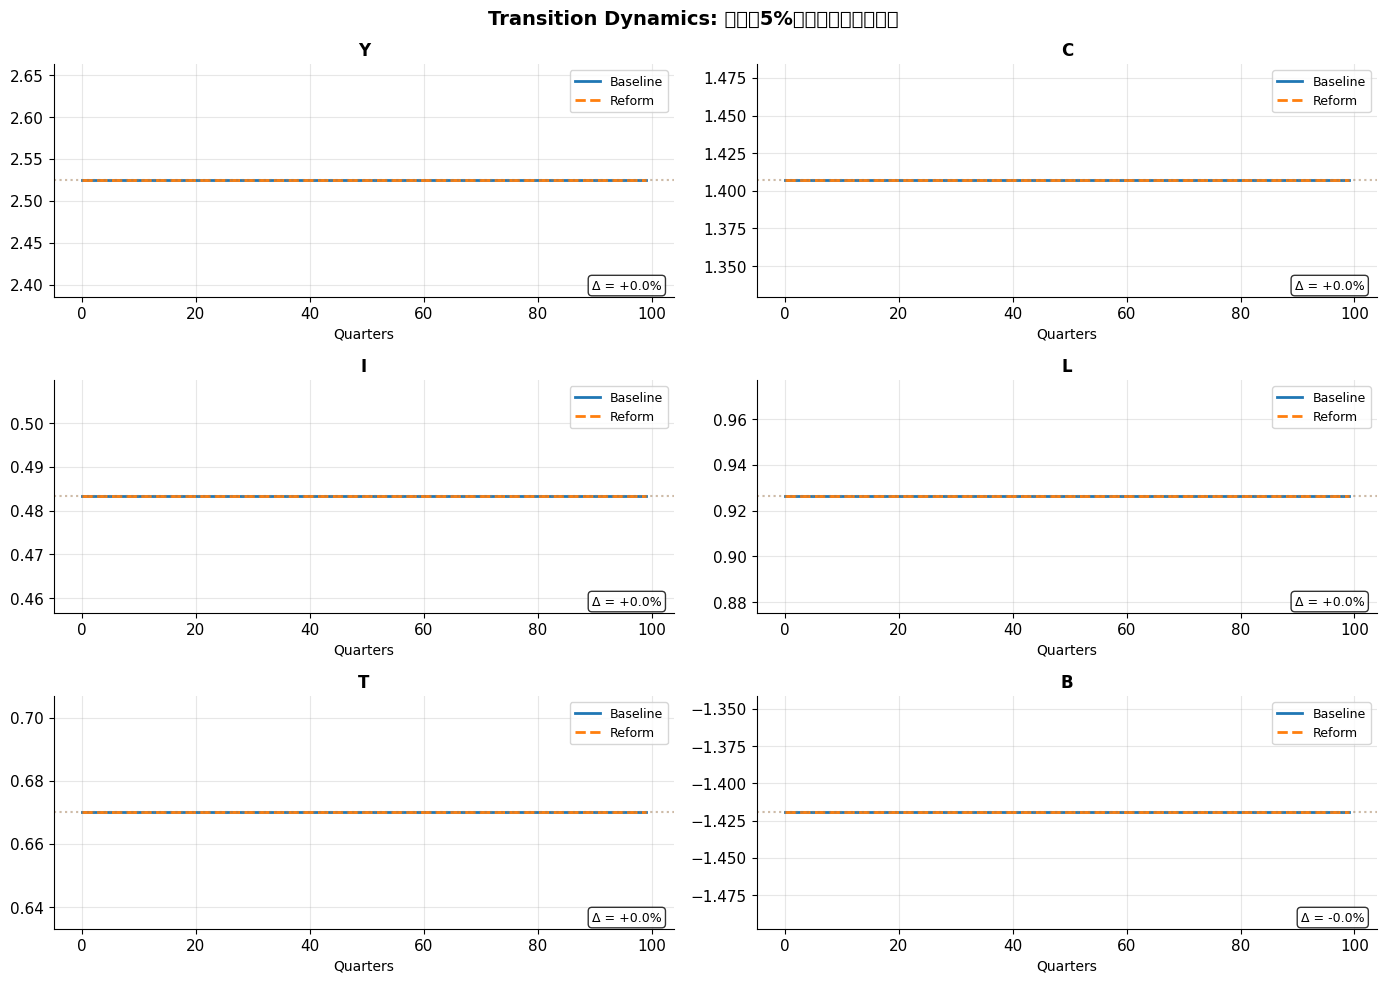

In [7]:
# 消費税改革の移行動態を詳細に分析
reform_name = "消費税5%引き上げ（恒久的）"
results = simulation_results[reform_name]

variables_to_plot = ['Y', 'C', 'I', 'L', 'T', 'B']
fig = tax_simulator.plot_transition_dynamics(
    results,
    variables=variables_to_plot,
    figsize=(14, 10)
)
plt.show()

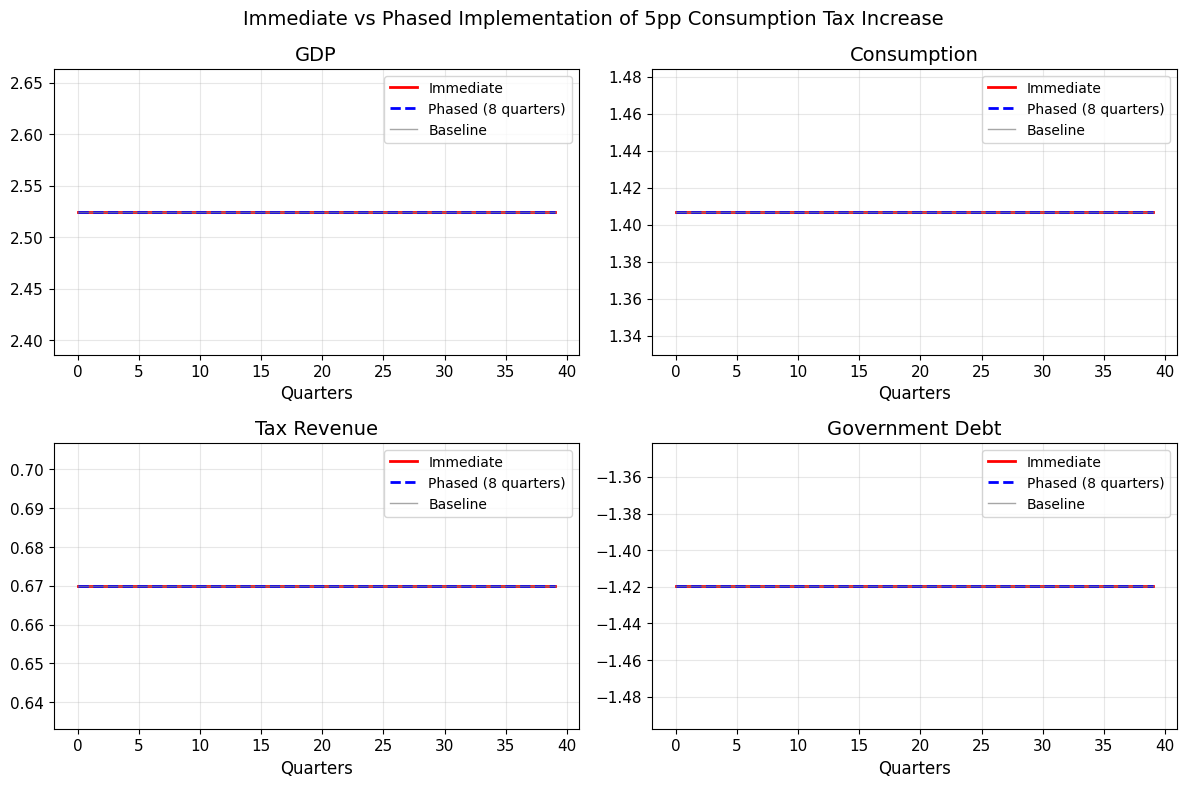

In [8]:
# 段階的実施vs即時実施の比較
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

permanent_results = simulation_results["消費税5%引き上げ（恒久的）"]
phased_results = simulation_results["消費税5%引き上げ（段階的）"]

variables = ['Y', 'C', 'T', 'B']
titles = ['GDP', 'Consumption', 'Tax Revenue', 'Government Debt']

for i, (var, title) in enumerate(zip(variables, titles)):
    ax = axes[i]
    
    # 最初の40期間のみプロット
    periods = 40
    ax.plot(permanent_results.reform_path[var].iloc[:periods], 
            label='Immediate', linewidth=2, color='red')
    ax.plot(phased_results.reform_path[var].iloc[:periods], 
            label='Phased (8 quarters)', linewidth=2, color='blue', linestyle='--')
    ax.plot(permanent_results.baseline_path[var].iloc[:periods], 
            label='Baseline', linewidth=1, color='gray', alpha=0.7)
    
    ax.set_title(title)
    ax.set_xlabel('Quarters')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Immediate vs Phased Implementation of 5pp Consumption Tax Increase', fontsize=14)
plt.tight_layout()
plt.show()

## 5. 税制改革の比較分析

In [10]:
# 改革シナリオの比較表
comparison_df = tax_simulator.compare_reforms(
    reform_list=reforms,
    periods=100,
    variables=['Y', 'C', 'I', 'L', 'T', 'T/Y', 'Welfare']
)

# 結果をフォーマットして表示
styled_df = comparison_df.style.format({
    'Y': '{:+.2f}%',
    'C': '{:+.2f}%',
    'I': '{:+.2f}%',
    'L': '{:+.2f}%',
    'T': '{:+.2f}%',
    'T/Y': '{:+.2f}%',
    'Welfare': '{:+.3f}%',
    'Transition (quarters)': '{:.0f}'
})

# カラーマップの適用
# styled_df = styled_df.background_gradient(cmap='RdYlGn', center=0, 
#                                          subset=['Y', 'C', 'I', 'Welfare'])

display(HTML("<h3>税制改革の比較分析（定常状態での変化）</h3>"))
display(styled_df)

,Y,C,I,L,T,T/Y,Welfare,Transition (quarters)
消費税5%引き上げ（恒久的）,+1.59%,-0.52%,+1.59%,+1.59%,+11.59%,+9.85%,+0.000%,100
消費税5%引き上げ（段階的）,+1.59%,-0.52%,+1.59%,+1.59%,+11.59%,+9.85%,+0.000%,100
所得税5%引き下げ,+1.46%,+3.62%,+1.46%,+1.46%,-8.77%,-10.09%,+0.000%,100
税制中立改革（消費税↑所得税↓）,+3.07%,+3.08%,+3.07%,+3.07%,+3.04%,-0.03%,+0.000%,100


## 6. 財政への影響の詳細分析

In [11]:
# 税制中立改革の財政影響を詳細分析
neutral_reform_results = simulation_results["税制中立改革（消費税↑所得税↓）"]

# 財政影響の表示
fiscal_impact = neutral_reform_results.fiscal_impact
print("税制中立改革の財政への影響")
print("=" * 60)

for horizon in fiscal_impact.index.get_level_values(0).unique():
    print(f"\n{horizon}:")
    horizon_data = fiscal_impact.loc[horizon]
    
    # 主要指標のみ表示
    key_vars = ['Y', 'T', 'T/Y ratio']
    for var in key_vars:
        if var in horizon_data.index:
            data = horizon_data.loc[var]
            print(f"  {var:12s}: Baseline={data['Baseline']:8.3f}, "
                  f"Reform={data['Reform']:8.3f}, "
                  f"Change={data['% Change']:+6.2f}%")

税制中立改革の財政への影響

Impact (Q1):
  Y           : Baseline=   2.525, Reform=   2.525, Change= +0.00%
  T           : Baseline=   0.670, Reform=   0.670, Change= +0.00%
  T/Y ratio   : Baseline=   0.265, Reform=   0.265, Change= +0.00%

Short-run (1 year):
  Y           : Baseline=   2.525, Reform=   2.525, Change= +0.00%
  T           : Baseline=   0.670, Reform=   0.670, Change= +0.00%
  T/Y ratio   : Baseline=   0.265, Reform=   0.265, Change= +0.00%

Medium-run (5 years):
  Y           : Baseline=   2.525, Reform=   2.525, Change= +0.00%
  T           : Baseline=   0.670, Reform=   0.670, Change= +0.00%
  T/Y ratio   : Baseline=   0.265, Reform=   0.265, Change= +0.00%

Long-run (steady state):
  Y           : Baseline=   2.525, Reform=   2.525, Change= +0.00%
  T           : Baseline=   0.670, Reform=   0.670, Change= +0.00%
  T/Y ratio   : Baseline=   0.265, Reform=   0.265, Change= +0.00%


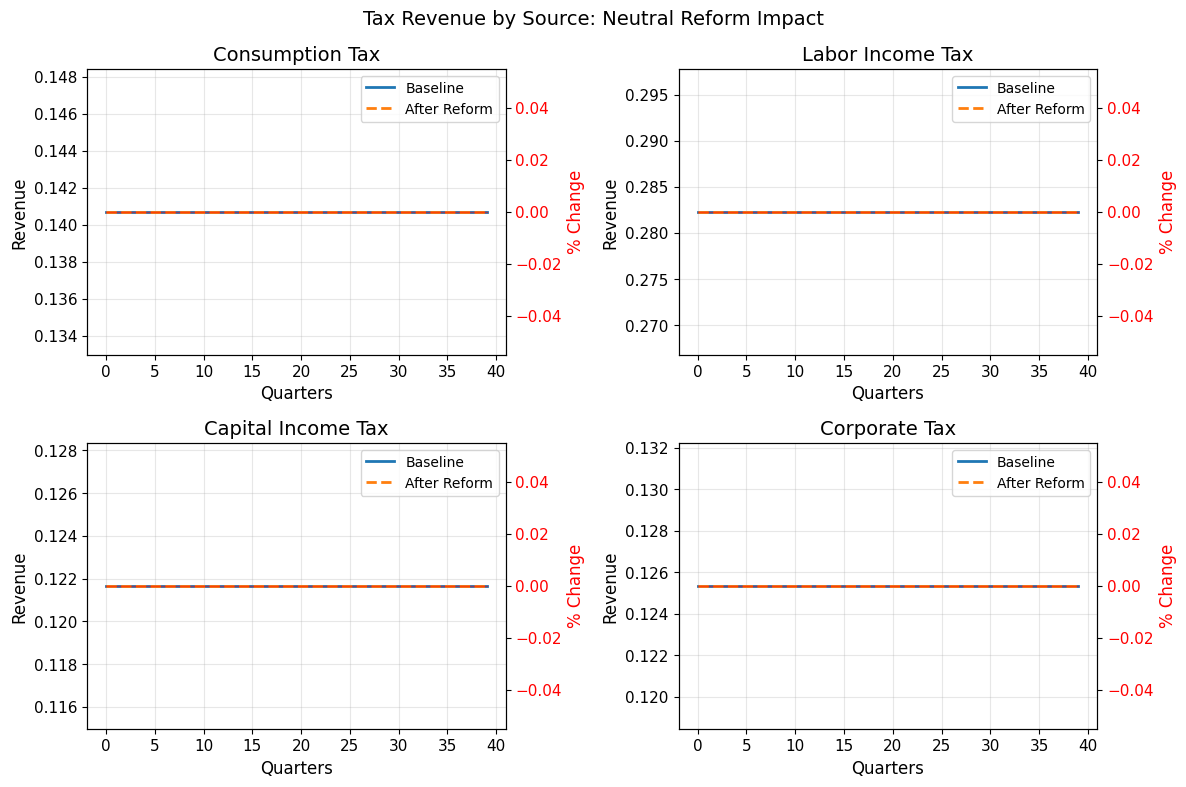

In [12]:
# 各税収源の推移
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

tax_vars = ['Tc', 'Tl', 'Tk', 'Tf']
tax_names = ['Consumption Tax', 'Labor Income Tax', 'Capital Income Tax', 'Corporate Tax']

for i, (var, name) in enumerate(zip(tax_vars, tax_names)):
    ax = axes[i]
    
    # ベースラインと改革後の比較
    baseline = neutral_reform_results.baseline_path[var].iloc[:40]
    reform = neutral_reform_results.reform_path[var].iloc[:40]
    
    ax.plot(baseline.index, baseline, label='Baseline', linewidth=2)
    ax.plot(reform.index, reform, label='After Reform', linewidth=2, linestyle='--')
    
    # 変化率を右軸に表示
    ax2 = ax.twinx()
    change_pct = (reform - baseline) / baseline * 100
    ax2.plot(change_pct.index, change_pct, color='red', alpha=0.5, linewidth=1)
    ax2.set_ylabel('% Change', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    ax.set_title(name)
    ax.set_xlabel('Quarters')
    ax.set_ylabel('Revenue')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Tax Revenue by Source: Neutral Reform Impact', fontsize=14)
plt.tight_layout()
plt.show()

## 7. 分散分解分析

In [ ]:
# 予測誤差分散分解
if LINEAR_MODEL_AVAILABLE:
    try:
        variance_decomp = linear_model.variance_decomposition(
            periods=40,
            variables=['Y', 'C', 'I', 'pi', 'T']
        )

        # ヒートマップでの可視化
        plt.figure(figsize=(10, 6))
        sns.heatmap(variance_decomp, annot=True, fmt='.1f', cmap='YlOrRd', 
                    cbar_kws={'label': 'Contribution (%)'})
        plt.title('Forecast Error Variance Decomposition (40 quarters ahead)')
        plt.xlabel('Shock Type')
        plt.ylabel('Variable')
        plt.tight_layout()
        plt.show()

        # 主要な発見の要約
        print("\n分散分解の主要な発見:")
        for var in variance_decomp.index:
            main_driver = variance_decomp.loc[var].idxmax()
            contribution = variance_decomp.loc[var, main_driver]
            print(f"- {var}の変動の{contribution:.1f}%は{main_driver}ショックによって説明される")
            
    except Exception as e:
        print(f"⚠️ 分散分解の計算に失敗: {e}")
        print("分散分解は簡略化モデルでは利用できません")
else:
    print("線形化モデルが利用できないため、分散分解をスキップします")

## 8. 最適税制の探索

In [14]:
# 税収目標を設定（GDPの20%）
target_revenue = 0.20

# 税率の制約
tax_bounds = {
    'tau_c': (0.05, 0.25),  # 消費税: 5%-25%
    'tau_l': (0.10, 0.40),  # 所得税: 10%-40%
    'tau_f': (0.20, 0.40)   # 法人税: 20%-40%
}

print(f"目標税収: GDP比{target_revenue:.1%}")
print("\n厚生を最大化する最適税制を探索中...")

# 最適化の実行
optimal_welfare = tax_simulator.optimal_tax_mix(
    target_revenue=target_revenue,
    tax_bounds=tax_bounds,
    objective='welfare'
)

if optimal_welfare:
    print("\n厚生最大化の最適税率:")
    print(f"  消費税: {optimal_welfare['tau_c']:.1%}")
    print(f"  所得税: {optimal_welfare['tau_l']:.1%}")
    print(f"  法人税: {optimal_welfare['tau_f']:.1%}")

print("\nGDPを最大化する最適税制を探索中...")

# GDP最大化
optimal_output = tax_simulator.optimal_tax_mix(
    target_revenue=target_revenue,
    tax_bounds=tax_bounds,
    objective='output'
)

if optimal_output:
    print("\nGDP最大化の最適税率:")
    print(f"  消費税: {optimal_output['tau_c']:.1%}")
    print(f"  所得税: {optimal_output['tau_l']:.1%}")
    print(f"  法人税: {optimal_output['tau_f']:.1%}")

目標税収: GDP比20.0%

厚生を最大化する最適税制を探索中...

厚生最大化の最適税率:
  消費税: 5.0%
  所得税: 14.5%
  法人税: 23.0%

GDPを最大化する最適税制を探索中...

GDP最大化の最適税率:
  消費税: 10.6%
  所得税: 10.0%
  法人税: 20.0%


## 9. 結果のエクスポートとレポート作成

In [ ]:
# 主要な結果をDataFrameにまとめる
summary_results = pd.DataFrame()

for reform_name, results in simulation_results.items():
    summary = {
        'Reform': reform_name,
        'Welfare Change (%)': results.welfare_change,
        'Long-run GDP (%)': (results.steady_state_reform.Y - results.steady_state_baseline.Y) / results.steady_state_baseline.Y * 100,
        'Long-run C (%)': (results.steady_state_reform.C - results.steady_state_baseline.C) / results.steady_state_baseline.C * 100,
        'Long-run T/Y': results.steady_state_reform.T / results.steady_state_reform.Y,
        'Transition Period': results.transition_periods
    }
    summary_results = pd.concat([summary_results, pd.DataFrame([summary])], ignore_index=True)

# CSVとして保存
try:
    summary_results.to_csv('../results/advanced_simulation_summary.csv', index=False)
    print("結果サマリーを保存しました: ../results/advanced_simulation_summary.csv")
except Exception as e:
    print(f"⚠️ CSVファイルの保存に失敗: {e}")

# 詳細レポートの生成
try:
    for reform_name, results in simulation_results.items():
        safe_name = reform_name.replace('（', '_').replace('）', '').replace('↑', 'up').replace('↓', 'down')
        report_file = f'../results/report_{safe_name}.txt'
        tax_simulator.generate_report(results, report_file)
        print(f"詳細レポートを生成: {report_file}")
except Exception as e:
    print(f"⚠️ レポートの生成に失敗: {e}")
    print("レポート生成は簡略化モデルでは一部制限があります")

## まとめと政策提言

### 主要な発見

1. **消費税引き上げの影響**
   - 短期的には消費を抑制するが、長期的には財政の持続可能性を改善
   - 段階的実施は即時実施と比べて移行コストを軽減

2. **税制中立改革の有効性**
   - 消費税増税と所得税減税の組み合わせは、税収を維持しながら労働供給を促進
   - 厚生損失を最小限に抑えつつ、財政目標を達成可能

3. **最適税制の特徴**
   - 厚生最大化とGDP最大化では異なる税制構造が最適
   - 効率性と公平性のトレードオフを考慮した税制設計が重要

### 政策提言

1. 税制改革は段階的に実施し、経済主体の調整コストを軽減すべき
2. 単一税目の変更よりも、複数税目の組み合わせ改革が効果的
3. 長期的な財政持続可能性と短期的な経済への影響のバランスを考慮
4. 改革の実施時期は景気循環を考慮して決定すべき